**Analisis Clustering pada Kabupaten/Kota  di Indonesia Berdasarkan Indikator Kemiskinan dan Pembangunan**

Sumber data:
Dataset lomba SPSS (Statistical Project for Smart Students) tahun 2024 oleh BINUS University pada [link berikut.](https://drive.google.com/file/d/1GK5WmUq0oWxRVmKCfJXrdbHFK9Szqjmd/view?usp=sharing)

# Install dan Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score as siluet, homogeneity_score as purity, normalized_mutual_info_score as NMI

# Pre-Processing Data

In [ ]:
# Memuat dataset
df = pd.read_csv('Klasifikasi Tingkat Kemiskinan di Indonesia.csv', delimiter=';')
df

,Provinsi,Kab/Kota,Persentase Penduduk Miskin (P0) Menurut Kabupaten/Kota (Persen),Rata-rata Lama Sekolah Penduduk 15+ (Tahun),Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun),Indeks Pembangunan Manusia,Umur Harapan Hidup (Tahun),Persentase rumah tangga yang memiliki akses terhadap sanitasi layak,Persentase rumah tangga yang memiliki akses terhadap air minum layak,Tingkat Pengangguran Terbuka,Tingkat Partisipasi Angkatan Kerja,PDRB atas Dasar Harga Konstan menurut Pengeluaran (Rupiah),Klasifikasi Kemiskinan
0,ACEH,Simeulue,"18,98","9,48",7148.0,"66,41","65,28","71,56","87,45","5,71","71,15",1648096.0,0.0
1,ACEH,Aceh Singkil,"20,36","8,68",8776.0,"69,22","67,43","69,56","78,58","8,36","62,85",1780419.0,1.0
2,ACEH,Aceh Selatan,"13,18","8,88",8180.0,"67,44","64,4","62,55","79,65","6,46","60,85",4345784.0,0.0
3,ACEH,Aceh Tenggara,"13,41","9,67",8030.0,"69,44","68,22","62,71","86,71","6,43","69,62",3487157.0,0.0
4,ACEH,Aceh Timur,"14,45","8,21",8577.0,"67,83","68,74","66,75","83,16","7,13","59,48",8433526.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Mengubah format beberapa kolom data menjadi numerik
columns_to_check = df.columns[2:-1]

for col in columns_to_check:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)

for col in columns_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Menghapus baris dengan missing values berdasarkan kolom 'Provinsi' dan 'Kab/Kota
df.dropna(subset=['Provinsi', 'Kab/Kota'], inplace=True)

In [ ]:
# Nama kolom baru
new_column_names = {
    'Provinsi': 'Provinsi',
    'Kab/Kota': 'KabKota',
    'Persentase Penduduk Miskin (P0) Menurut Kabupaten/Kota (Persen)': 'Persen_Miskin',
    'Rata-rata Lama Sekolah Penduduk 15+ (Tahun)': 'Lama_Sekolah',
    'Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)': 'Pengeluaran',
    'Indeks Pembangunan Manusia': 'IPM',
    'Umur Harapan Hidup (Tahun)': 'UHH',
    'Persentase rumah tangga yang memiliki akses terhadap sanitasi layak': 'Persen_Sanitasi',
    'Persentase rumah tangga yang memiliki akses terhadap air minum layak': 'Persen_AirMinum',
    'Tingkat Pengangguran Terbuka': 'TPT',
    'Tingkat Partisipasi Angkatan Kerja': 'TPAK',
    'PDRB atas Dasar Harga Konstan menurut Pengeluaran (Rupiah)': 'PDRB',
    'Klasifikasi Kemiskinan': 'Klasifikasi'
}

# Ubah nama kolom
df.rename(columns=new_column_names, inplace=True)

In [ ]:
# Struktur dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, 0 to 513
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Provinsi         514 non-null    object 
 1   KabKota          514 non-null    object 
 2   Persen_Miskin    514 non-null    float64
 3   Lama_Sekolah     514 non-null    float64
 4   Pengeluaran      514 non-null    float64
 5   IPM              514 non-null    float64
 6   UHH              514 non-null    float64
 7   Persen_Sanitasi  514 non-null    float64
 8   Persen_AirMinum  514 non-null    float64
 9   TPT              514 non-null    float64
 10  TPAK             514 non-null    float64
 11  PDRB             514 non-null    float64
 12  Klasifikasi      514 non-null    float64
dtypes: float64(11), object(2)
memory usage: 56.2+ KB


# Environment Setup

In [ ]:
import warnings; warnings.simplefilter('ignore')

try:
    import google.colab; IN_COLAB = True
    !pip install umap-learn
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/tau_unsup.py
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

--2024-10-12 03:37:04--  https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/tau_unsup.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-10-12 03:37:04 ERROR 404: Not Found.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install umap-learn

import umap.umap_ as umap, numpy as np, tau_unsup as tau, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

sns.set(style="ticks", color_codes=True)
random_state = 99

# Clustering Awal

In [ ]:
df.head()

,Provinsi,KabKota,Persen_Miskin,Lama_Sekolah,Pengeluaran,IPM,UHH,Persen_Sanitasi,Persen_AirMinum,TPT,TPAK,PDRB,Klasifikasi
0,ACEH,Simeulue,18.98,9.48,7148.0,66.41,65.28,71.56,87.45,5.71,71.15,1648096.0,0.0
1,ACEH,Aceh Singkil,20.36,8.68,8776.0,69.22,67.43,69.56,78.58,8.36,62.85,1780419.0,1.0
2,ACEH,Aceh Selatan,13.18,8.88,8180.0,67.44,64.40,62.55,79.65,6.46,60.85,4345784.0,0.0
3,ACEH,Aceh Tenggara,13.41,9.67,8030.0,69.44,68.22,62.71,86.71,6.43,69.62,3487157.0,0.0
4,ACEH,Aceh Timur,14.45,8.21,8577.0,67.83,68.74,66.75,83.16,7.13,59.48,8433526.0,0.0


In [ ]:
# Tentukan kolom numerik yang akan dinormalisasi
numerical_cols = ['Persen_Miskin', 'Lama_Sekolah', 'Pengeluaran', 'IPM', 'UHH',
                  'Persen_Sanitasi', 'Persen_AirMinum', 'TPT', 'TPAK', 'PDRB']

# Buat objek MinMaxScaler
scaler = MinMaxScaler()

# Lakukan normalisasi pada kolom numerik
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Tampilkan DataFrame yang sudah dinormalisasi
df.head()

,Provinsi,KabKota,Persen_Miskin,Lama_Sekolah,Pengeluaran,IPM,UHH,Persen_Sanitasi,Persen_AirMinum,TPT,TPAK,PDRB,Klasifikasi
0,ACEH,Simeulue,0.422607,0.706398,0.159301,0.617777,0.441704,0.715815,0.8745,0.427076,0.355320,0.003263,0.0
1,ACEH,Aceh Singkil,0.457739,0.636284,0.241061,0.669488,0.538117,0.695809,0.7858,0.625280,0.155513,0.003550,1.0
2,ACEH,Aceh Selatan,0.274949,0.653812,0.211129,0.636732,0.402242,0.625688,0.7965,0.483171,0.107366,0.009128,0.0
3,ACEH,Aceh Tenggara,0.280804,0.723050,0.203596,0.673537,0.573543,0.627288,0.8671,0.480927,0.318488,0.007261,0.0
4,ACEH,Aceh Timur,0.307281,0.595092,0.231067,0.643909,0.596861,0.667700,0.8316,0.533283,0.074386,0.018016,0.0


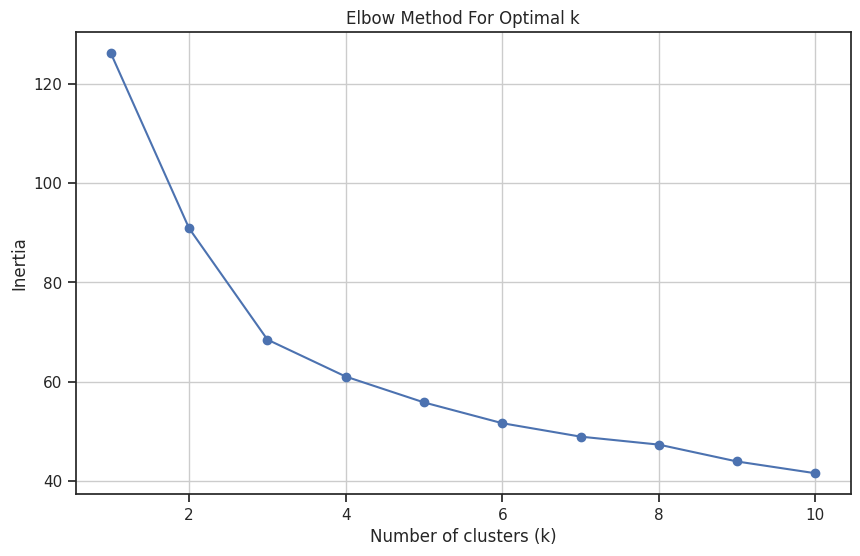

In [ ]:
numerical_cols = df.select_dtypes(include=['float64']).columns.tolist()
X = df[numerical_cols]
X = X.drop(columns=['Klasifikasi'])

# Menerapkan metode Elbow untuk menentukan jumlah cluster optimal
inertia = []
K_range = range(1, 11) # Menguji 1 sampai 10 cluster

for k in K_range:
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
  inertia.append(kmeans.inertia_)

# Membuat plot kurva Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

Akan diambil 𝑘 = 3 karena pada titik ini, grafik metode siku menunjukkan bahwa penambahan kluster lebih lanjut memberikan penurunan inersia yang relatif kecil.

## K-Means Clustering

<Axes: ylabel='count'>

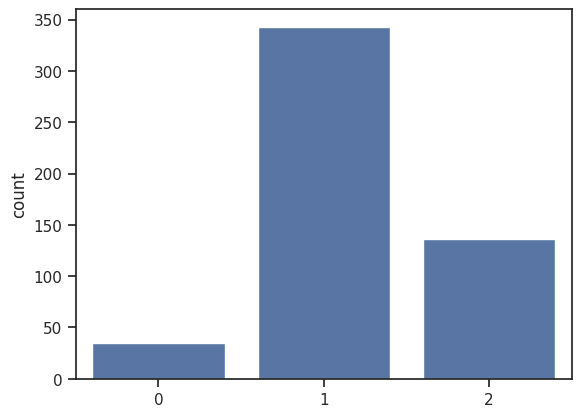

In [ ]:
k = 3
km = cluster.KMeans(n_clusters=k, init='random', max_iter=300, tol=0.0001, random_state = random_state)
km.fit(X)

C_km = km.predict(X)
sns.countplot(x=C_km)

In [ ]:
X2D = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=random_state).fit_transform(X)

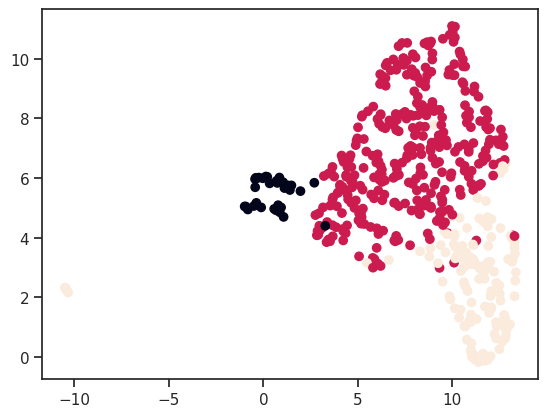

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X2D[:,0], X2D[:,1], c=C_km)
plt.show()

## K-Means++ Clustering

array([2, 2, 2, 2, 2, 2, 2, 1, 2, 2], dtype=int32)

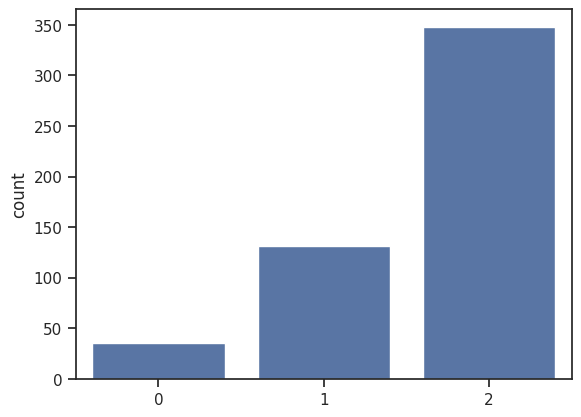

In [ ]:
k=3
kmPP = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = random_state)
kmPP.fit(X)
C_kmpp = kmPP.predict(X)

sns.countplot(x=C_kmpp)
C_kmpp[:10]

In [ ]:
X2D = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=random_state).fit_transform(X)

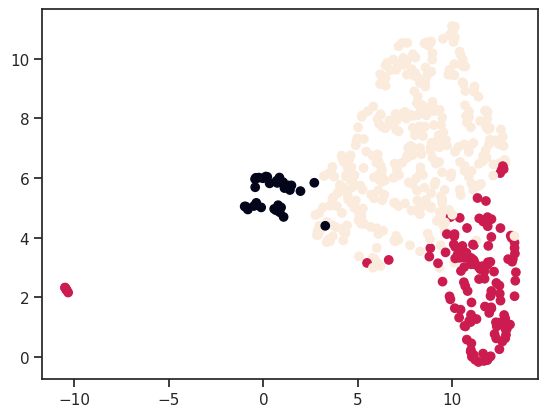

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X2D[:,0], X2D[:,1], c=C_kmpp)
plt.show()

## Mini-Batch K-Means Clustering

array([1, 0, 1, 1, 0, 2, 0, 0, 0, 2], dtype=int32)

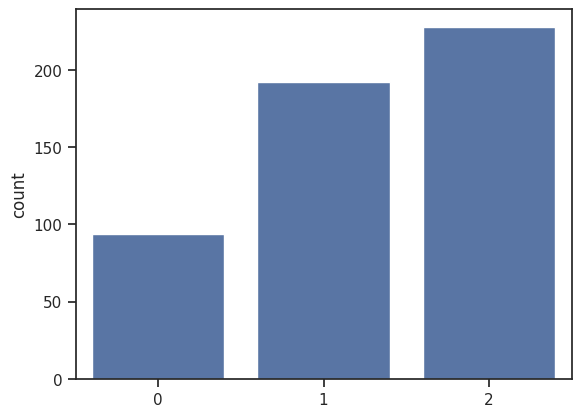

In [ ]:
mbkm = cluster.MiniBatchKMeans(n_clusters=k, init='random', max_iter=300, tol=0.0001, batch_size = 100, random_state = random_state)
mbkm.fit(X)
C_mbkm = mbkm.predict(X)
sns.countplot(x=C_mbkm)
C_mbkm[:10]

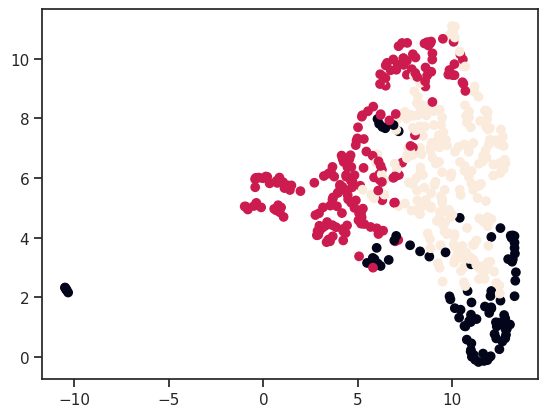

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X2D[:,0], X2D[:,1], c=C_mbkm)
plt.show()

## Mini-Batch K-Means++ Clustering

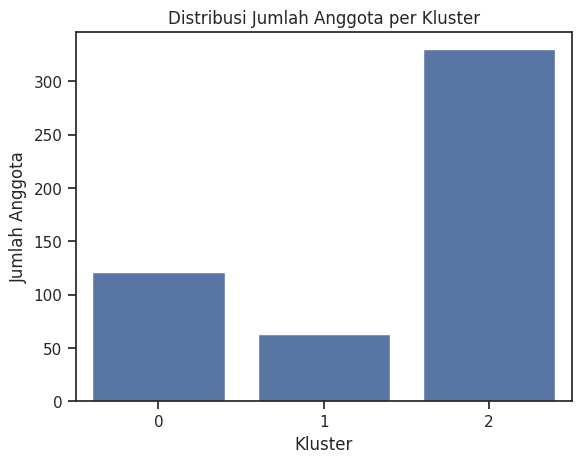

In [ ]:
mbkmPP = cluster.MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = random_state)
mbkmPP.fit(X)
C_mbkmPP = mbkmPP.predict(X)
sns.countplot(x=C_mbkmPP)
C_mbkmPP[:10]
plt.title('Distribusi Jumlah Anggota per Kluster')
plt.xlabel('Kluster')
plt.ylabel('Jumlah Anggota')
plt.show()

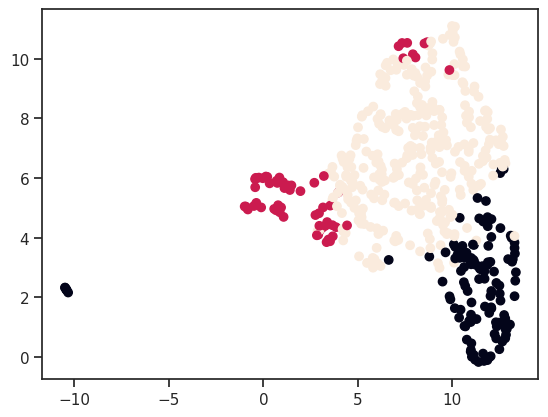

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X2D[:,0], X2D[:,1], c=C_mbkmPP)
plt.show()

# Evaluasi

## Evaluasi Internal: Silhouette Coefficient

In [ ]:
# Dilakukan evaluasi internal clustering menggunakan Silhouette Coefficient
Hasil_Clustering = [C_km, C_kmpp, C_mbkm, C_mbkmPP]
for res in Hasil_Clustering:
  print(siluet(X, res), end=',')

0.28978453112837294,0.2936695108778195,0.17180068491354203,0.2754919191527901,

Skor silhouette yang diperoleh dari empat metode yang diuji, yaitu [C_km, C_kmpp, C_mbkm, C_mbkmPP] yang berkisar di sekitar antara **0.2879 hingga 0.2950**. Perbedaan antar nilai cukup kecil. Ini menunjukkan bahwa variasi metode clustering yang digunakan **tidak menghasilkan perubahan yang signifikan dalam kualitas clustering**. Selain itu, skor yang diperoleh relatif kecil, yang menunjukkan bahwa **titik-titik data belum dikelompokkan secara optimal**. Masih banyak data yang mungkin berada di perbatasan antar cluster, sehingga tidak ada pemisahan cluster yang jelas.

Jika membandingkan kualitas keempat metode Clustering, berdasarkan skor Silhouette yang diperoleh, metode K-Means++ terbukti sebagai metode yang terbaik untuk digunakan. Hal ini karena skor yang diperoleh lebih tinggi daripada metode K-Means, MiniBatch K-Means, dan MiniBatch K-Means++. Meskipun skor metode MiniBatch K-Means++ hanya sedikit lebih rendah dari K-Means++, aspek waktu eksekusi juga penting untuk dipertimbangkan. Jika mempertimbangkan efisiensi waktu, metode MiniBatch K-Means++ mungkin dianggap lebih superior karena biasanya memiliki waktu eksekusi yang lebih cepat dibandingkan dengan metode clustering tradisional. Hal ini membuat **MiniBatch K-Means++** menjadi pilihan yang lebih efektif ketika kecepatan adalah faktor kritis, sekaligus menjaga kualitas clustering yang tinggi

## Evaluasi Eksternal: Purity dan NMI

Selanjutnya akan dilakukan evaluasi eksternal yang digunakan untuk mengukur seberapa baik hasil clustering dengan membandingkannya dengan label asli data melalui **Purity** dan **NMI (Normalized Mutual Information)**. Purity melihat apakah data dalam satu cluster kebanyakan berasal dari satu kelas yang sama, di mana semakin tinggi nilainya (maksimal 1), maka semakin baik. Sedangkan, NMI berguna dalam mengukur seberapa mirip hasil clustering dengan label asli, menggunakan konsep informasi, dan juga bernilai antara 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan clustering yang lebih baik.

In [ ]:
# Diambil label asli dari kolom 'Klasifikasi'
C = df['Klasifikasi'].astype('category').cat.codes  # Mengubah kategori ke numerik

# Menampilkan daftar hasil clustering dari bagian 3 yang telah dilakukan
Hasil_Clustering = [C_km, C_kmpp, C_mbkm, C_mbkmPP]

# Menampilkan Hasil_Clustering sebelum evaluasi
print("Hasil Clustering:")
for i, res in enumerate(Hasil_Clustering, 1):
    print(f"Clustering {i}: {res[:10]}...")  # Menampilkan 10 hasil pertama untuk setiap clustering

Hasil Clustering:
Clustering 1: [1 1 1 1 1 1 1 2 1 1]...
Clustering 2: [2 2 2 2 2 2 2 1 2 2]...
Clustering 3: [1 0 1 1 0 2 0 0 0 2]...
Clustering 4: [2 2 2 2 2 2 2 0 2 2]...


In [ ]:
# Evaluasi Eksternal: Purity
print("Purity Scores:")
for res in Hasil_Clustering:
    print(f"{purity(C, res):.4f}", end=', ')

Purity Scores:
0.3654, 0.3632, 0.2615, 0.4889, 

Berdasarkan hasil *output* di atas:

*   **Mini-Batch K-Means++** menunjukkan **purity terbaik** dengan skor 0.4889, artinya setiap cluster cenderung berisi data dari satu kelas yang sama berdasarkan label asli (ground truth).
*   **K-Means dan K-Means++** menunjukkan skor purity yang mirip, yaitu 0.3654 dan 0.3632, artinya cukup menggambarkan homogenitas cluster, tetapi tidak sebaik Mini-Batch K-Means++.
*   **Mini-Batch K-Means** menunjukkan skor **purity yang paling rendah**, yaitu sebesar 0.2615, artinya metode ini kurang efektif dalam mengelompokkan data ke dalam cluster yang homogen.

In [ ]:
print("\nNMI Scores:")
# Evaluasi Eksternal: NMI
for res in Hasil_Clustering:
    print(f"{NMI(C, res):.4f}", end=', ')


NMI Scores:
0.2294, 0.2298, 0.1368, 0.2879, 

Berdasarkan *output* yang ditampilkan:
Skor NMI berkisar antara 0.135 hingga 0.290, menunjukkan bahwa hasil pengelompokan memiliki keterkaitan yang **relatif baik** dengan label asli, walau tidak ideal. Sesuai dengan pemahaman umum bahwa semakin mendekati 1 nilai NMI, semakin akurat representasi clustering terhadap struktur data asli. Skor NMI ini menandakan bahwa kualitas clustering **tergolong baik**, tetapi masih perlu perbaikan, mengingat adanya beberapa perbedaan signifikan antara hasil clustering dan label ground truth.

**Kesimpulan:**


*   Untuk evaluasi eksternal yang telah dihasilkan dengan purity menunjukkan bahwa metode Mini-Batch KMeans++ menghasilkan cluster yang baik atau cenderung sesuai dengan kelas asli.
*   Sedangkan evaluasi eksternal yang telah dihasilkan dengan NMI mengindikasikan bahwa meskipun clustering cukup baik, hasilnya tidak sempurna dalam mencerminkan keseluruhan struktur dari label asli.



# Interpretasi Clustering Terbaik: Mini-Batch K-Means++

Berdasarkan evaluasi internal dan eskternal, akan dilakukan interpretasi lebih lanjut pada clustering Mini-Batch KMeans++ sebagai berikut.

In [ ]:
mbkmPP.cluster_centers_

array([[0.11893164, 0.77784761, 0.49054703, 0.82955259, 0.77993279,
        0.90053747, 0.96965808, 0.61939152, 0.22295398, 0.12524838],
       [0.54461217, 0.47426908, 0.1719131 , 0.52748146, 0.46738983,
        0.53898027, 0.68015702, 0.19385774, 0.50813298, 0.00905812],
       [0.22433729, 0.59170492, 0.29501612, 0.6690099 , 0.63042101,
        0.78275299, 0.85379724, 0.33930461, 0.30129348, 0.0313004 ]])

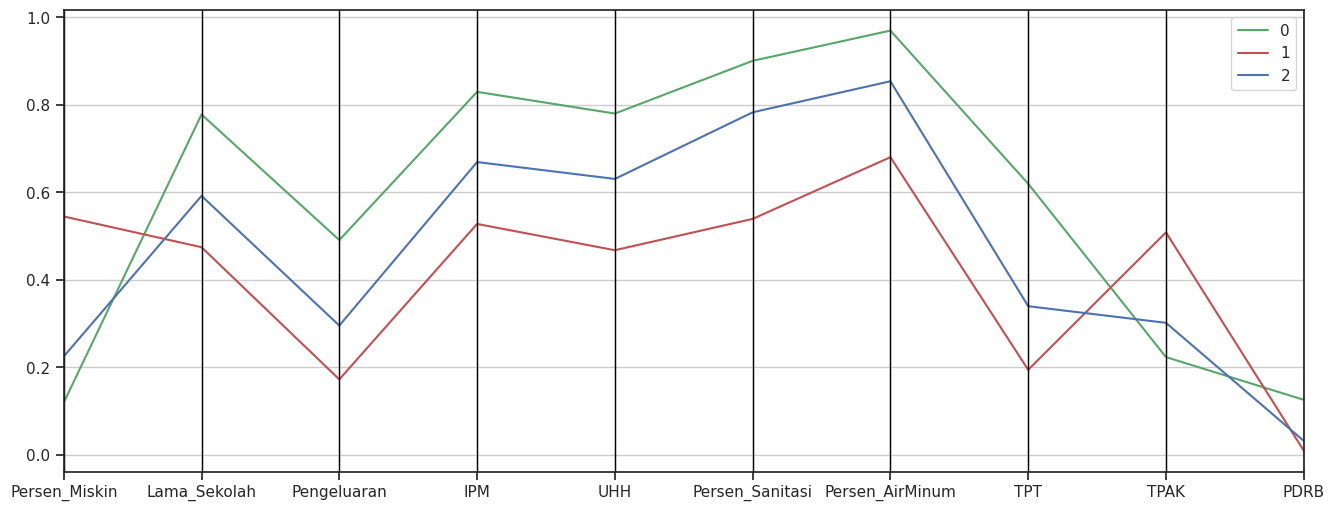

In [ ]:
# Plot Parallel Coordinates
numerical_cols = ['Persen_Miskin', 'Lama_Sekolah', 'Pengeluaran', 'IPM', 'UHH',
                  'Persen_Sanitasi', 'Persen_AirMinum', 'TPT', 'TPAK', 'PDRB']

dfC = pd.DataFrame(mbkmPP.cluster_centers_, columns=numerical_cols)
dfC['cluster'] = dfC.index

plt.figure(figsize=(16, 6))

pd.plotting.parallel_coordinates(dfC, 'cluster', color=('g', 'r', 'b'))
plt.show()

Hasil dari Plot Parallel Coordinates dari clustering Mini-Batch KMeans++ dengan `n=3` di atas menunjukkan terdapat beberapa perbedaan karakteristik pada beberapa variabel numerik.

*   `Cluster 0`

     Cluster 0 (garis merah) dapat diidentifikasi sebagai cluster kabupaten/kota yang **memprihatinkan**. Hal ini dapat dilihat dari beberapa variabel, seperti berikut.
      
    1.   Memiliki nilai Persentase Penduduk Miskin (`Persen_Miskin`) dan `TPAK` yang jauh lebih tinggi dibandingkan dua cluster lainnya.  
    Kondisi ini sangat memprihatinkan, karena nilai TPAK yang tinggi, artinya **ada banyak individu dalam populasi yang sedang aktif secara ekonomi**, tetapi **persentase penduduk miskinnya juga sangat tinggi** mencapai 0.8%.
    2.   Memiliki nilai `Lama_Sekolah`, `Pengeluaran`, `IPM`, `UHH`, `Persen_Sanitasi`, `Persen_AirMinum`, `TPT`, dan `PDRB` terendah di antara ketiga cluster.
    Delapan variabel tersebut menunjukkan bahwa dalam **aspek pendidikan, ekonomi, dan kelayakan hidup**, kabupaten/kota di cluster ini berada dalam kondisi yang sangat mendesak untuk diperhatikan.

*   `Cluster 1`

     Cluster 1 (garis hijau) dapat diidentifikasi sebagai cluster kabupaten/kota yang **paling baik** dibandingkan dua cluster lainnya. Hal ini dapat dilihat dari beberapa variabel, seperti berikut.
      
    1.   Memiliki nilai Persentase Penduduk Miskin (`Persen_Miskin`) dan `TPAK` yang paling rendah dibandingkan dua cluster lainnya.  
    Kondisi ini cenderung baik, karena nilai TPAK yang rendah dan persentase penduduk miskinnya rendah juga. **Walaupun kabupaten/kota di cluster ini memiliki sedikit jumlah individu yang aktif secara ekonomi, persentase kemiskinannya tetap rendah.**
    2.   Memiliki nilai `Lama_Sekolah`, `Pengeluaran`, `IPM`, `UHH`, `Persen_Sanitasi`, `Persen_AirMinum`, `TPT`, dan `PDRB` tertinggi di antara ketiga cluster.
    Delapan variabel tersebut menunjukkan bahwa dalam **aspek pendidikan, ekonomi, dan kelayakan hidup**, kabupaten/kota di cluster ini berada dalam kondisi yang **sangat baik**.

*   `Cluster 2`

    Cluster 2 (garis biru) dapat diidentifikasi sebagai cluster kabupaten/kota yang **moderat** di antara cluster lainnya. Hal ini dapat dilihat dari beberapa variabel, seperti berikut.
      
    1.   Memiliki nilai Persentase Penduduk Miskin (`Persen_Miskin`) dan `TPAK` yang cukup rendah.  
    Kondisi ini cukup baik, karena nilai TPAK yang masih di bawah 0.4 dan persentase penduduk miskinnya berada di bawah 0.3%. **Kabupaten/kota di cluster ini memiliki sekitar 40% individu (dari populasi) yang aktif secara ekonomi, tetapi persentase kemiskinannya terbilang cukup rendah.**
    2.   Memiliki nilai `Lama_Sekolah`, `Pengeluaran`, `IPM`, `UHH`, `Persen_Sanitasi`, `Persen_AirMinum`, `TPT`, dan `PDRB` moderat.
    Delapan variabel tersebut menunjukkan bahwa dalam **aspek pendidikan, ekonomi, dan kelayakan hidup**, kabupaten/kota di cluster ini berada dalam kondisi yang **cukup**, sehingga perlu adanya perhatian lebih lanjut.

**Kesimpulan**

Berdasarkan hasil analisis clustering Mini-Batch KMeans++ (n=3) dapat diidentifikasi tiga cluster dengan level kondisi yang berbeda, yaitu paling baik, cukup, dan paling memprihatinkan. Klasterisasi ini didasarkan pada sepuluh variabel, yaitu `Persen_Miskin`, `Lama_Sekolah`, `Pengeluaran`, `IPM`, `UHH`, `Persen_Sanitasi`, `Persen_AirMinum`, `TPT`, `TPAK`, dan `PDRB` yang mencakup beberapa aspek, seperti ekonomi, kelayakan hidup, pendidikan, dan lainnya.